## Notebook Purpose
1. Join the media csv file generated within with the predictions file to capture data about the predictions.
2. Show some statistics by the hour for predicted species counts.


## Data ETL and Cleaning

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Read in data
preds_df = pd.read_csv('2025-06-29_predictions_with_url.csv')
media_df = pd.read_csv('../../output/media.csv', low_memory=False)
deplo_df = pd.read_csv('../../output/deployments.csv')

In [29]:
# Take a look at data
print("------------------------- Preds: -------------------------")
display(preds_df.head(1))
print("------------------------- Media: -------------------------")
display(media_df.head(1))
print("------------------------- Deploys: -------------------------")
display(deplo_df.head(1))


------------------------- Preds: -------------------------


mediaID    predicted_class   common_name  \
0  002fe9a5dc3a1bf6b14298838bae6982  Branta_canadensis  Canada Goose   

   probability                                               top3  \
0       0.9101  Canada Goose: 0.9101, Mallard: 0.0161, Beaver:...   

                                           publicURL  
0  https://urbanriverrangers.s3.amazonaws.com/ima...

------------------------- Media: -------------------------


mediaID deploymentID  captureMethod  \
0  c112813a5f3b9cec26f95fad982b8d09          NaN            NaN   

              timestamp                                           filePath  \
0  2024-01-24T18:56:50Z  https://urbanriverrangers.s3.amazonaws.com/ima...   

   filePublic      fileName fileMediatype  \
0        True  SYFW0001.JPG    image/jpeg   

                                            exifData  favorite mediaComments  
0  {"Make": "TC", "Model": "XG2", "Software": "R2...     False           NaN

------------------------- Deploys: -------------------------


deploymentID                locationID locationName  latitude  \
0  66e5dee8f8e217337ca907a5  66e5dee8f8e217337ca907a5           da       NaN   

   longitude  coordinateUncertainty  deploymentStart  deploymentEnd  \
0        NaN                    NaN              NaN            NaN   

                    setupBy  cameraID  ...  cameraTilt  cameraHeading  \
0  66e5dea41b229c3dfd805772       NaN  ...         NaN            NaN   

   detectionDistance  timestampIssues  baitUse  featureType  habitat  \
0                NaN              NaN      NaN          NaN      NaN   

   deploymentGroups  deploymentTags  deploymentComments  
0               NaN             NaN                 NaN  

[1 rows x 24 columns]

In [30]:
merged_df = pd.merge(preds_df, media_df, how='left', on='mediaID')

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71905 entries, 0 to 71904
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mediaID          71905 non-null  object 
 1   predicted_class  71905 non-null  object 
 2   common_name      71905 non-null  object 
 3   probability      71905 non-null  float64
 4   top3             71905 non-null  object 
 5   publicURL        71905 non-null  object 
 6   deploymentID     20527 non-null  object 
 7   captureMethod    0 non-null      float64
 8   timestamp        71905 non-null  object 
 9   filePath         71905 non-null  object 
 10  filePublic       71905 non-null  bool   
 11  fileName         71905 non-null  object 
 12  fileMediatype    71905 non-null  object 
 13  exifData         45491 non-null  object 
 14  favorite         71905 non-null  bool   
 15  mediaComments    66 non-null     object 
dtypes: bool(2), float64(2), object(12)
memory usage: 7.8+ MB
N

In [31]:
# Grab the gps data if it exists and make a mini deployment df
import json

# Function to safely extract location from exifData JSON string
def extract_location(exif_json):
    try:
        if pd.isna(exif_json) or exif_json == "":
            return [None, None]
        data = json.loads(exif_json)
        loc = data.get("location")
        if loc and isinstance(loc, list) and len(loc) == 2:
            return loc
        return [None, None]
    except Exception:
        return [None, None]

# Apply extraction to the media_df to get longitude and latitude columns
media_df[['longitude', 'latitude']] = media_df['exifData'].apply(lambda x: pd.Series(extract_location(x)))

# Create a new DataFrame for deployments with GPS, grouped by deploymentID
# Only include rows where both longitude and latitude are not null

deplo_gps_df = (
    media_df.dropna(subset=['longitude', 'latitude'])
            .groupby('mediaID')[['longitude', 'latitude']]
            .first()
            .reset_index()
)

deplo_gps_df.head()

mediaID  longitude  latitude
0  0005e48d5a711ded9645de05bc5cc927  -87.65236  41.90740
1  000630d3c5300bf4d30b79332464ba4a  -87.65236  41.90740
2  000777b9c61675c64cfa169a3649990f  -87.65024  41.84806
3  000f94fb612c1c62b51cc4c81714f246  -87.65024  41.84806
4  001023e47e1b1fa217d0bafe37520735  -87.65019  41.84804

In [32]:
deplo_gps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31589 entries, 0 to 31588
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mediaID    31589 non-null  object 
 1   longitude  31589 non-null  float64
 2   latitude   31589 non-null  float64
dtypes: float64(2), object(1)
memory usage: 740.5+ KB


In [33]:
# second merge with deploys
merged_df = pd.merge(merged_df, deplo_gps_df, how='left', on='mediaID')
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71905 entries, 0 to 71904
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mediaID          71905 non-null  object 
 1   predicted_class  71905 non-null  object 
 2   common_name      71905 non-null  object 
 3   probability      71905 non-null  float64
 4   top3             71905 non-null  object 
 5   publicURL        71905 non-null  object 
 6   deploymentID     20527 non-null  object 
 7   captureMethod    0 non-null      float64
 8   timestamp        71905 non-null  object 
 9   filePath         71905 non-null  object 
 10  filePublic       71905 non-null  bool   
 11  fileName         71905 non-null  object 
 12  fileMediatype    71905 non-null  object 
 13  exifData         45491 non-null  object 
 14  favorite         71905 non-null  bool   
 15  mediaComments    66 non-null     object 
 16  longitude        10446 non-null  float64
 17  latitude    

The location data is very sparse - let's ignore for now

In [34]:
selected_cols = [
    'mediaID', 'predicted_class', 'common_name', 'probability', 'publicURL', 'deploymentID', 'timestamp', 'latitude', 'longitude'
]

media_preds = merged_df[selected_cols]
media_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71905 entries, 0 to 71904
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mediaID          71905 non-null  object 
 1   predicted_class  71905 non-null  object 
 2   common_name      71905 non-null  object 
 3   probability      71905 non-null  float64
 4   publicURL        71905 non-null  object 
 5   deploymentID     20527 non-null  object 
 6   timestamp        71905 non-null  object 
 7   latitude         10446 non-null  float64
 8   longitude        10446 non-null  float64
dtypes: float64(3), object(6)
memory usage: 4.9+ MB


In [35]:
# Ensure timestamp is datetime and hour is extracted
media_preds = media_preds.copy()
media_preds['timestamp'] = pd.to_datetime(media_preds['timestamp'], errors='coerce')
media_preds.loc[:, 'hour'] = media_preds['timestamp'].dt.hour

# Group by species and hour, count occurrences
species_hour_counts = media_preds.groupby(['common_name', 'hour']).size().reset_index(name='count')

# Normalize counts for each species
species_hour_counts['norm_count'] = round(species_hour_counts.groupby('common_name')['count'].transform(lambda x: x / x.max()),3)

display(species_hour_counts.head())

common_name  hour  count  norm_count
0      Beaver     0    203       0.832
1      Beaver     1    152       0.623
2      Beaver     2    127       0.520
3      Beaver     3    134       0.549
4      Beaver     4    129       0.529

## Visualizations

In [36]:
media_preds['common_name'].value_counts()

common_name
Mallard                          15675
Blank                             8672
Small Brown/Grey Songbirds        8413
Colorful Songbirds & Thrushes     5755
Turtles                           5443
Canada Goose                      5265
Domestic Dog                      4866
Norway Rat                        4549
Raccoon                           3071
Beaver                            2717
Iridescent Blackbirds             2157
Virginia Opossum                  1603
Domestic Cat                      1048
Great Blue Heron                   895
Eastern Cottontail                 846
Coyote                             358
Black-crowned Night Heron          316
Gulls                              256
Name: count, dtype: int64

### Time Series

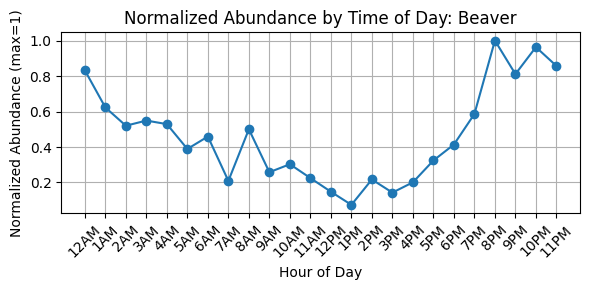

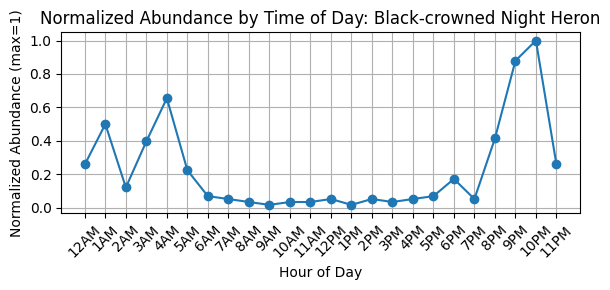

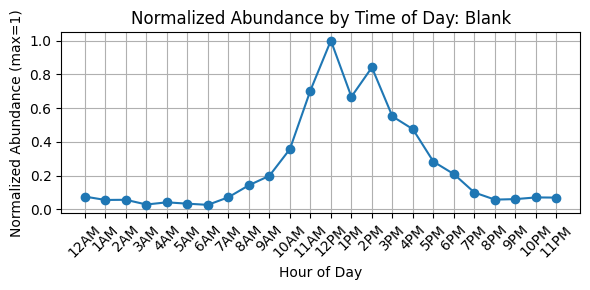

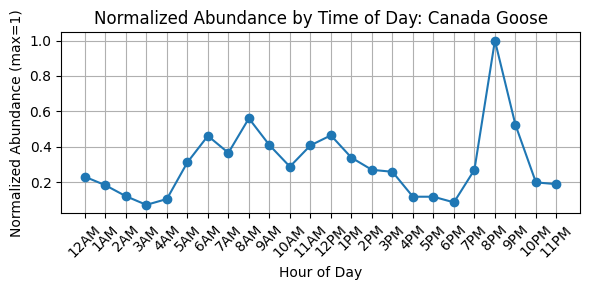

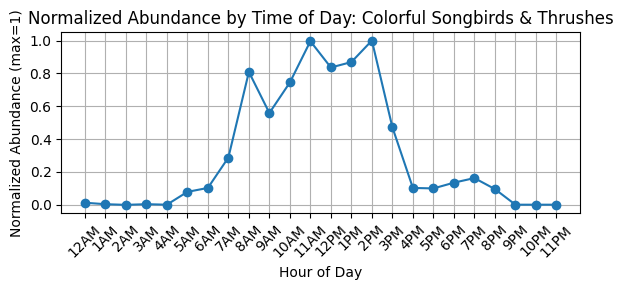

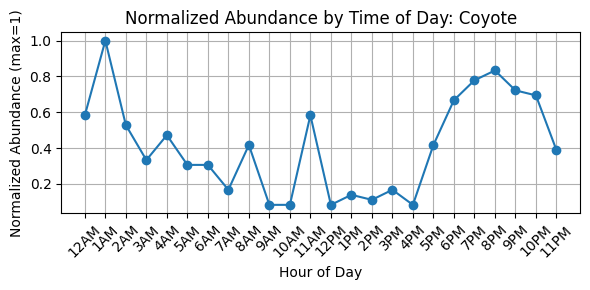

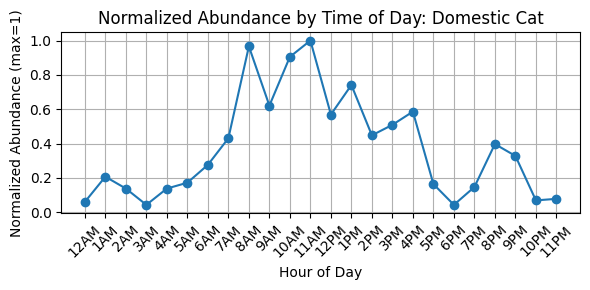

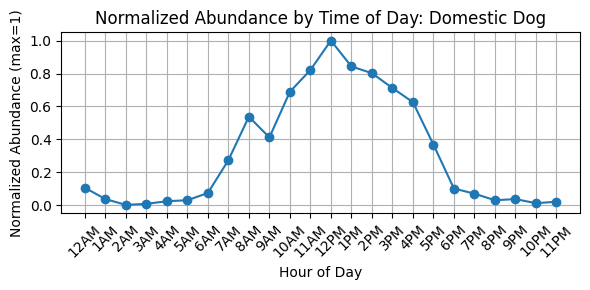

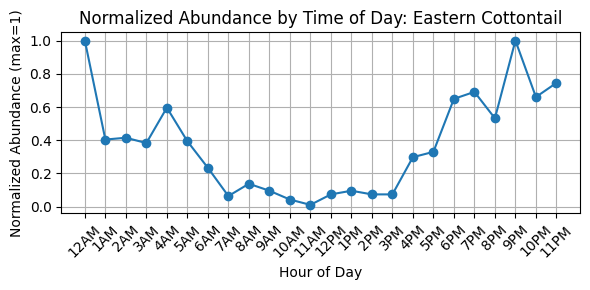

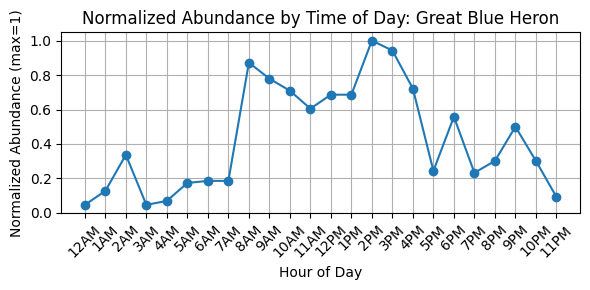

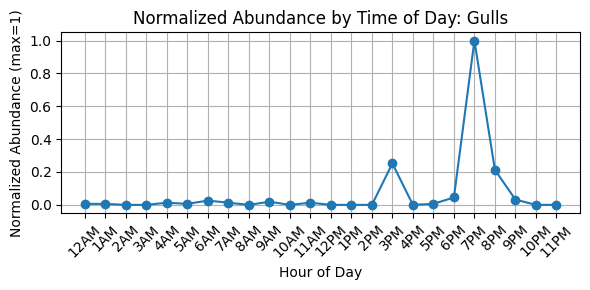

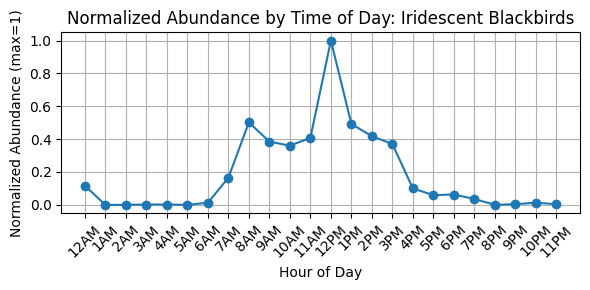

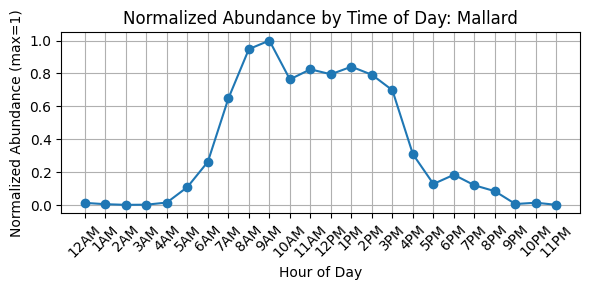

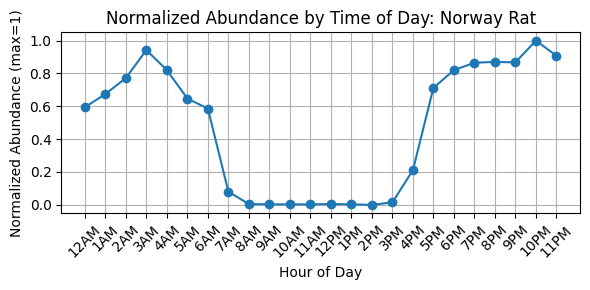

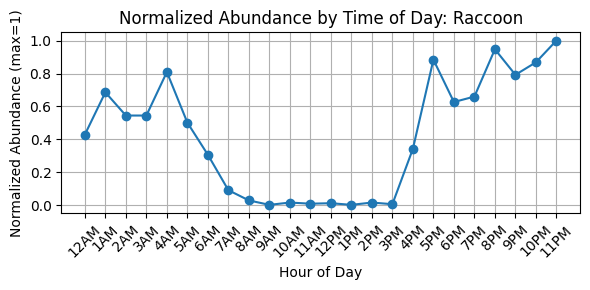

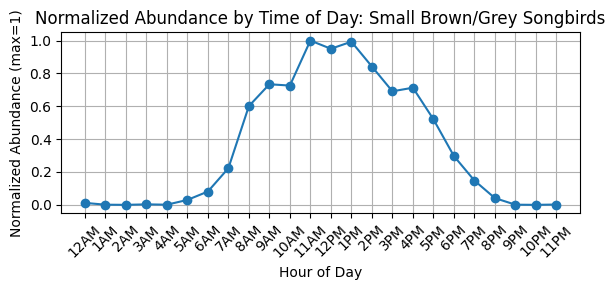

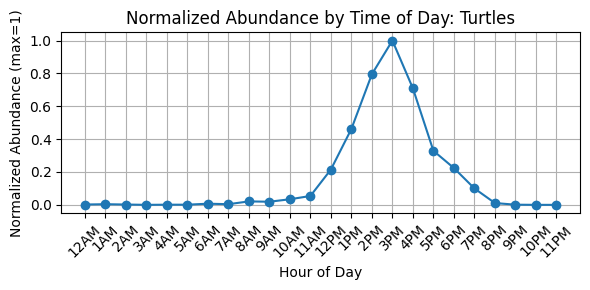

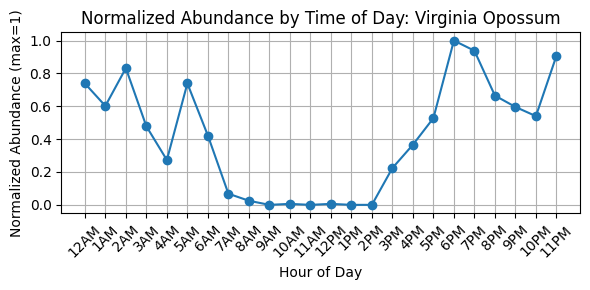

In [37]:
# Plot for each species
species_list = species_hour_counts['common_name'].unique()

hours = range(24)
hour_labels = [f"{h%12 if h%12 else 12}{'AM' if h < 12 else 'PM'}" for h in hours]

for species in species_list:
    data = species_hour_counts[species_hour_counts['common_name'] == species]
    # add 0s for missing data
    data = data.set_index('hour').reindex(hours, fill_value=0).reset_index()

    plt.figure(figsize=(6, 3))
    plt.plot(
        data['hour'],
        data['norm_count'],
        marker='o',
        color='tab:blue'
    )
    plt.xticks(hours, hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Abundance (max=1)')
    plt.title(f'Normalized Abundance by Time of Day: {species}')
    plt.grid(True)
    plt.tight_layout()
    



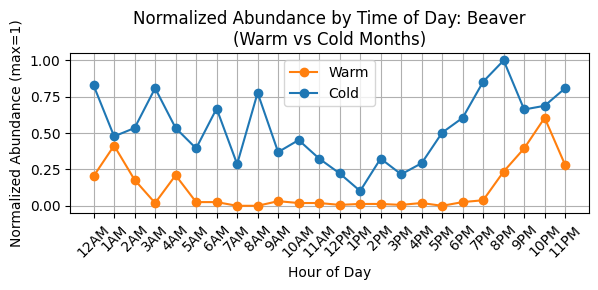

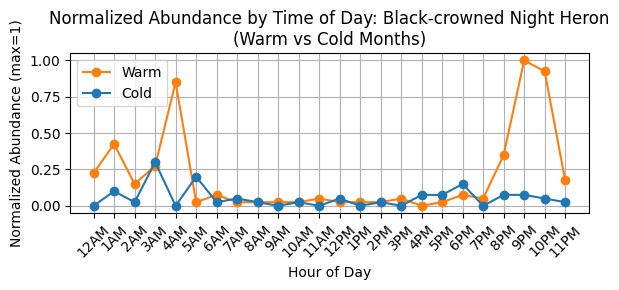

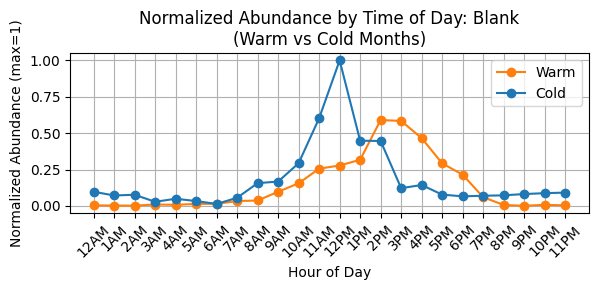

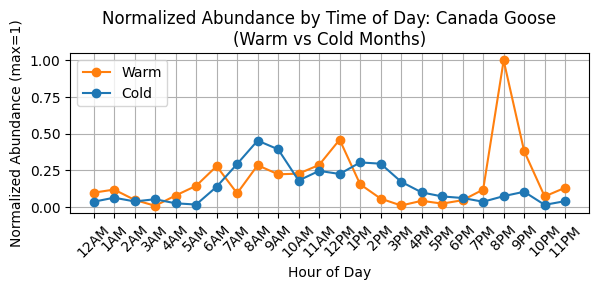

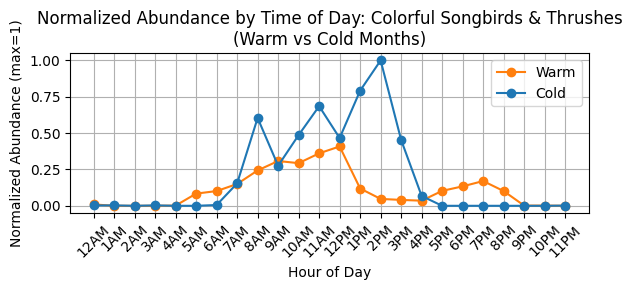

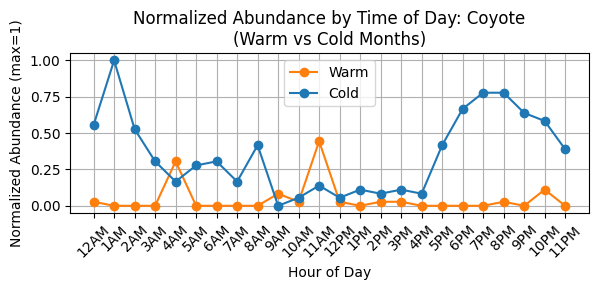

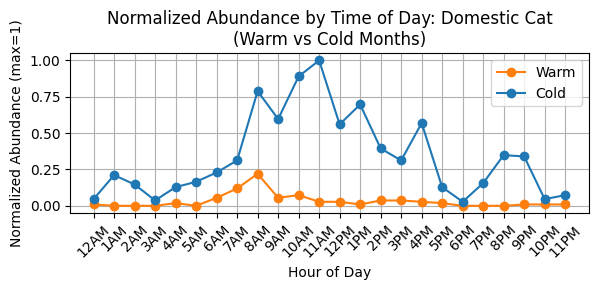

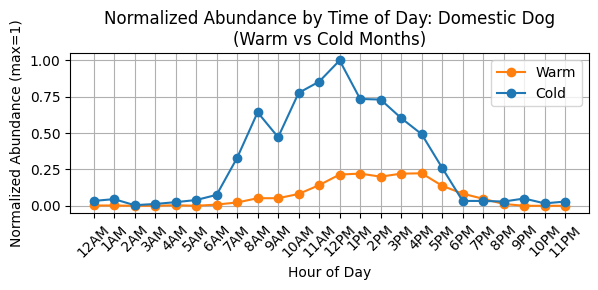

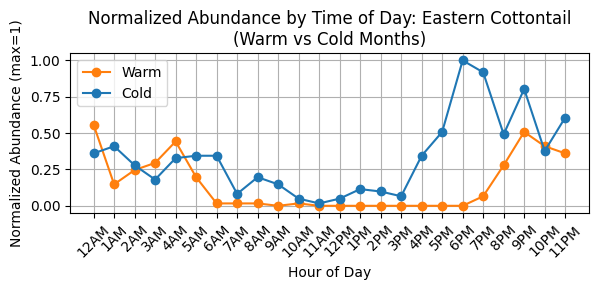

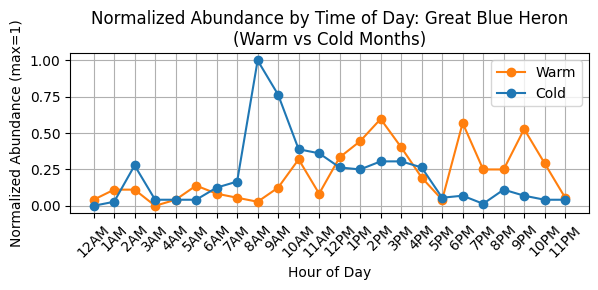

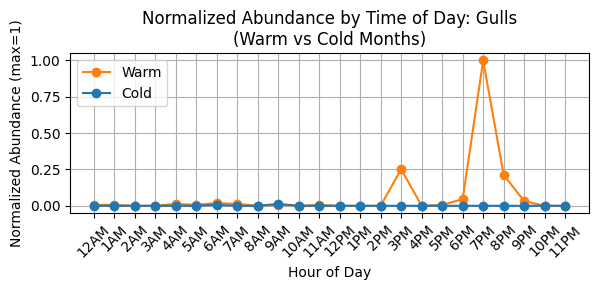

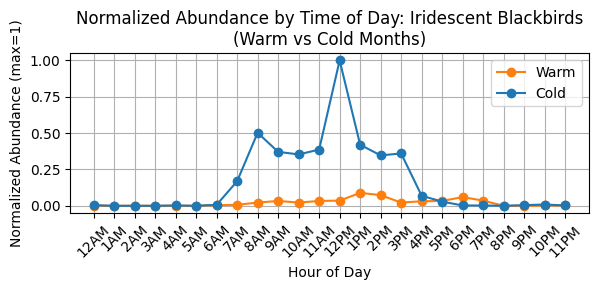

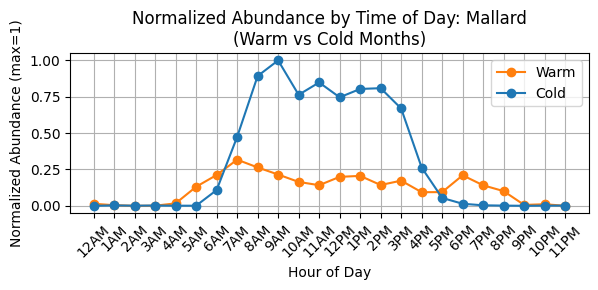

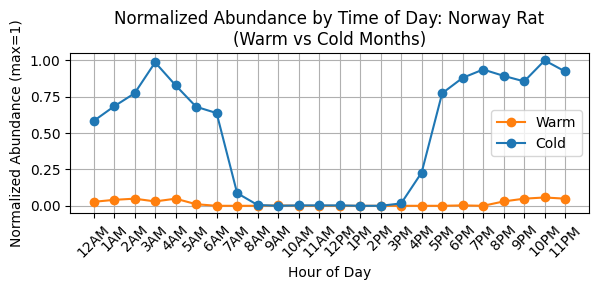

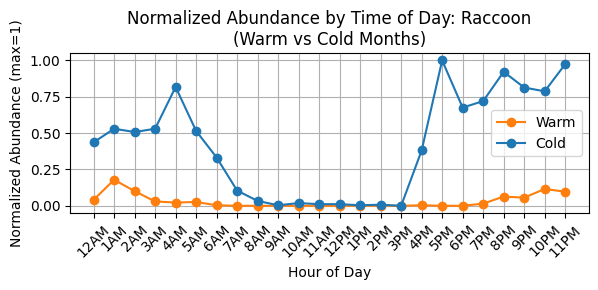

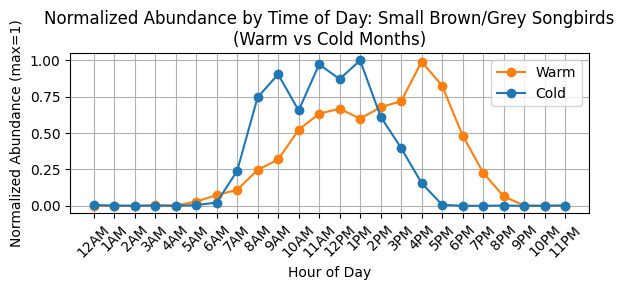

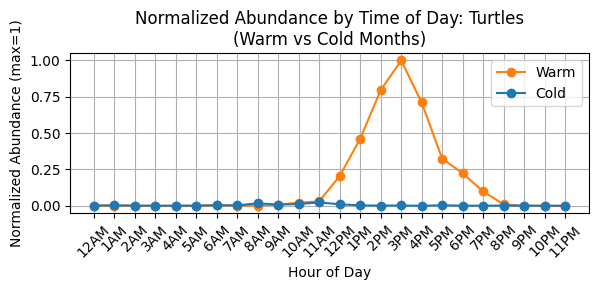

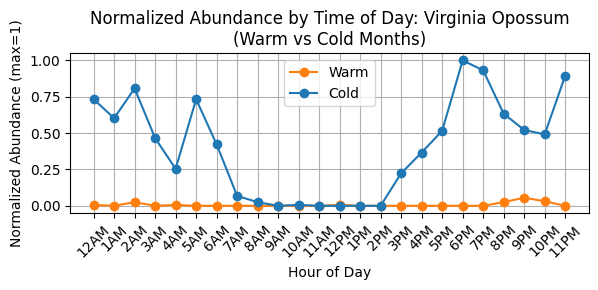

In [38]:
# Plot warm vs cold months for each species
# Define warm (May–Sep) and cold (Nov–Mar) months
warm_months = [5, 6, 7, 8, 9]
cold_months = [11, 12, 1, 2, 3]

# Work on a copy to avoid SettingWithCopyWarning
media_preds = media_preds.copy()

# Ensure timestamp is datetime and extract month and hour
media_preds['timestamp'] = pd.to_datetime(media_preds['timestamp'], errors='coerce')
media_preds['month'] = media_preds['timestamp'].dt.month
media_preds['hour'] = media_preds['timestamp'].dt.hour

# Assign season
media_preds['season'] = np.where(media_preds['month'].isin(warm_months), 'Warm',
                          np.where(media_preds['month'].isin(cold_months), 'Cold', 'Other'))

# Only keep warm and cold
seasonal = media_preds[media_preds['season'].isin(['Warm', 'Cold'])].copy()

# Group by species, season, hour
seasonal_counts = (
    seasonal.groupby(['common_name', 'season', 'hour'])
    .size().reset_index(name='count')
)
# Normalize within each species+season
seasonal_counts['norm_count'] = seasonal_counts.groupby(['common_name'])['count'].transform(lambda x: x / x.max())

species_list = seasonal_counts['common_name'].unique()
hours = range(24)
hour_labels = [f"{h%12 if h%12 else 12}{'AM' if h < 12 else 'PM'}" for h in hours]

for species in species_list:
    plt.figure(figsize=(6, 3))
    for season, color in zip(['Warm', 'Cold'], ['tab:orange', 'tab:blue']):
        data = seasonal_counts[(seasonal_counts['common_name'] == species) & (seasonal_counts['season'] == season)]
        data = data.set_index('hour').reindex(hours, fill_value=0).reset_index()
        plt.plot(
            data['hour'],
            data['norm_count'],
            marker='o',
            color=color,
            label=season
        )
    plt.xticks(hours, hour_labels, rotation=45)
    plt.xlabel('Hour of Day')
    plt.ylabel('Normalized Abundance (max=1)')
    plt.title(f'Normalized Abundance by Time of Day: {species}\n(Warm vs Cold Months)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Radar Plots

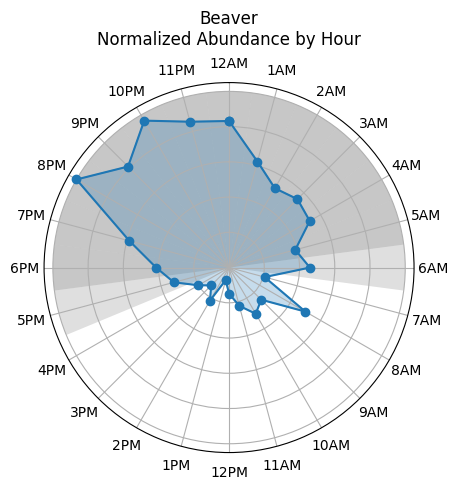

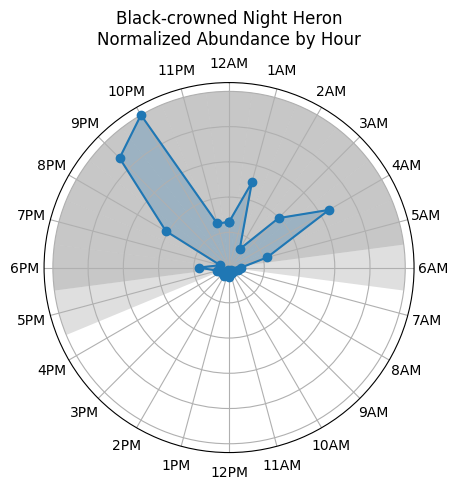

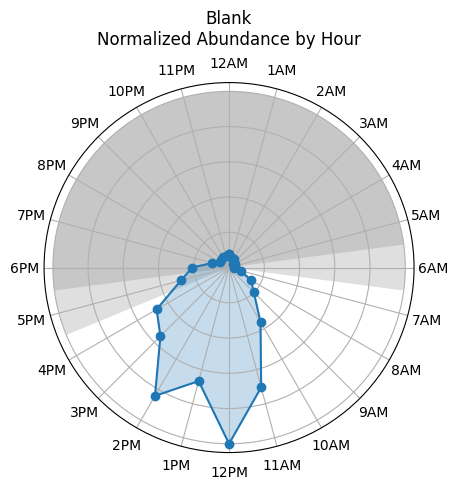

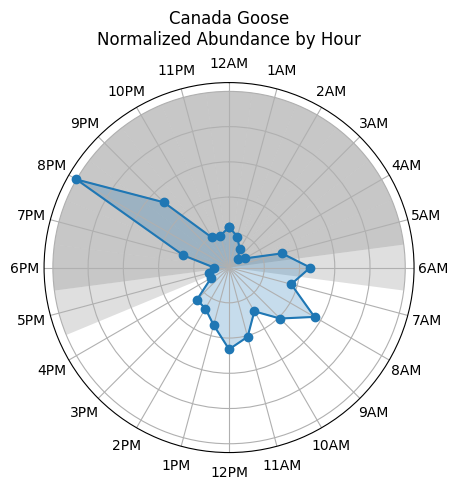

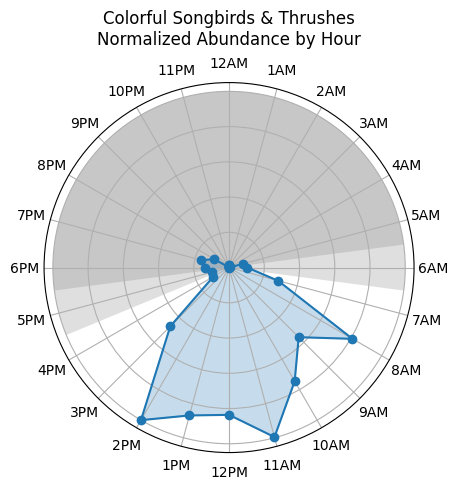

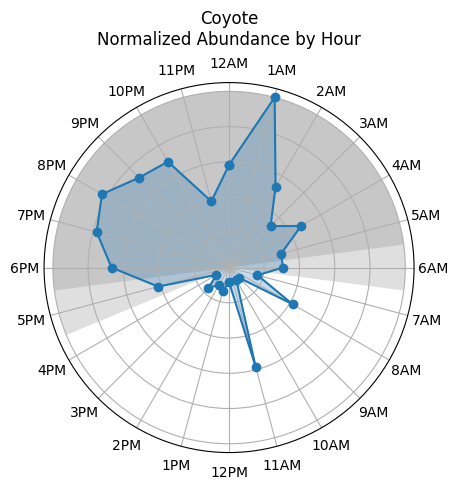

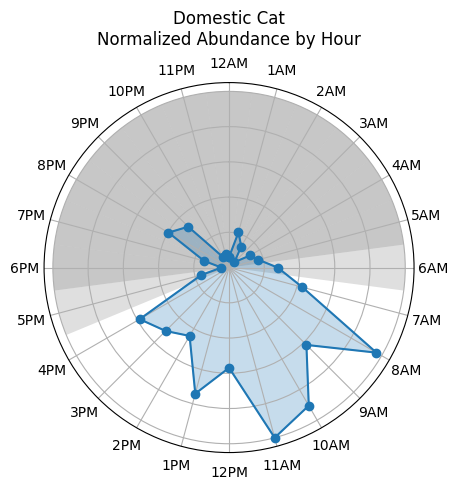

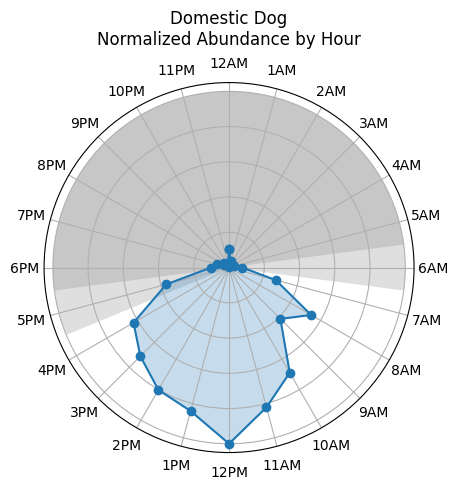

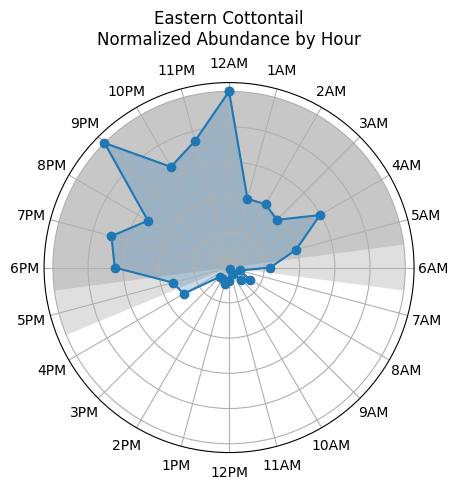

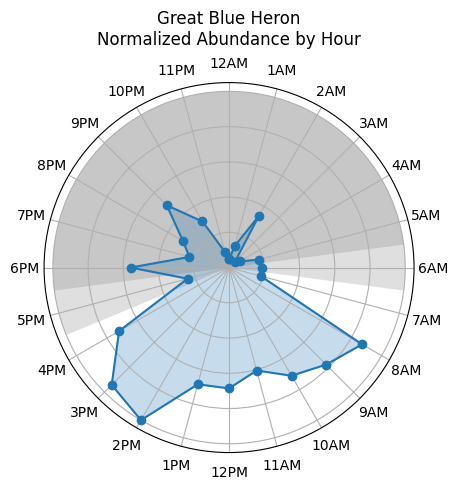

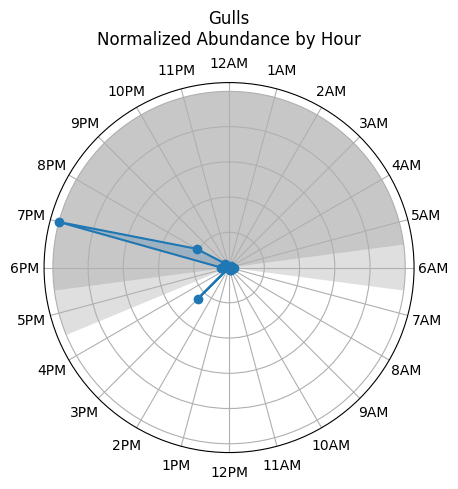

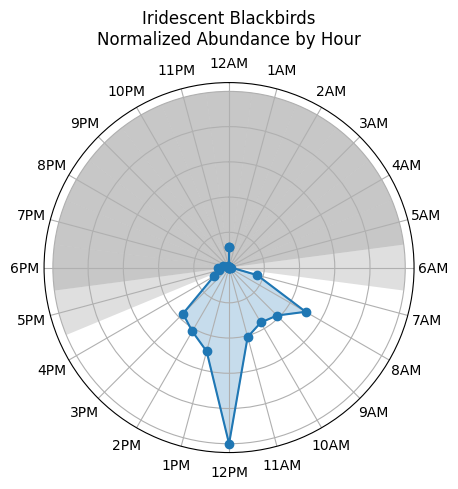

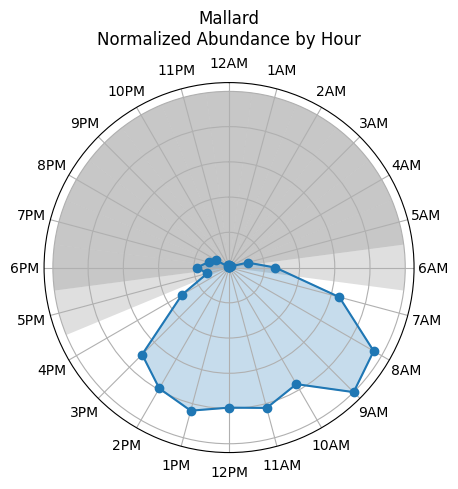

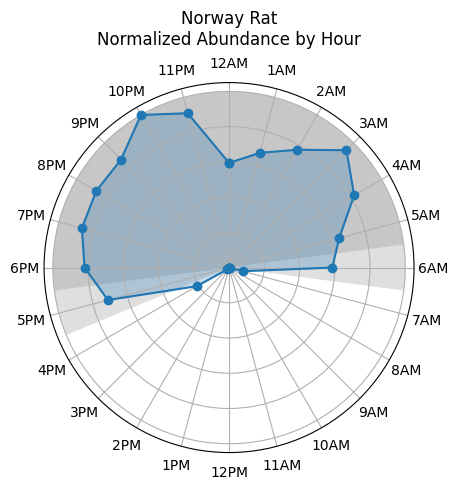

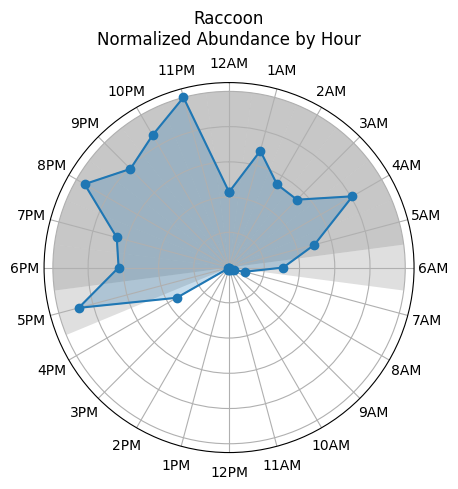

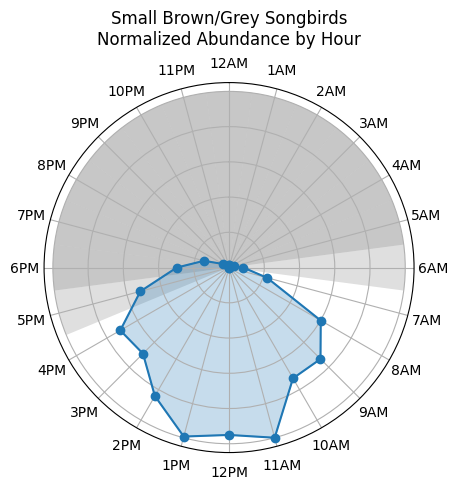

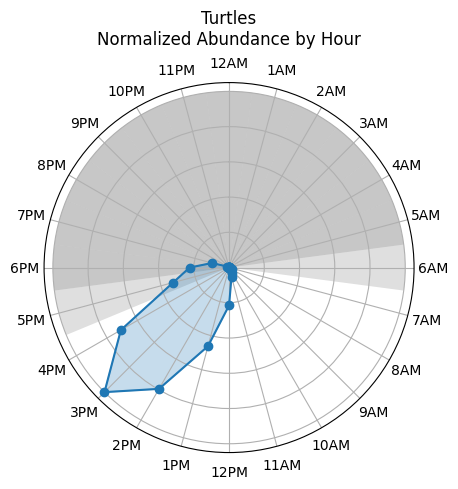

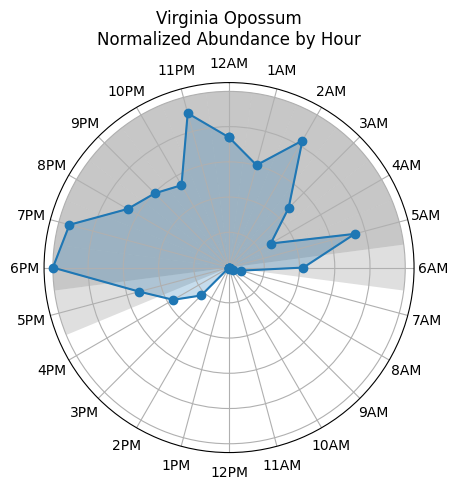

In [ ]:
# Overall combining all months and years
species_list = species_hour_counts['common_name'].unique()
hours = np.arange(24)
angles = np.deg2rad(hours * (360 / 24))  # map 0–23 to radians (0–2π)
hour_labels = [f"{h%12 if h%12 else 12}{'AM' if h < 12 else 'PM'}" for h in hours]

for species in species_list:
    data = species_hour_counts[species_hour_counts['common_name'] == species]
    data = data.set_index('hour').reindex(hours, fill_value=0).reset_index()
    
    values = data['norm_count'].values
    values = np.append(values, values[0])            # close the loop
    angles_full = np.append(angles, angles[0])

    # Create plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, polar=True)

    # Rotate so 12 AM is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Shade night time: from 5 PM (17) to 5 AM (5)
    night_hours = list(range(17, 24)) + list(range(0, 6))
    for h in night_hours:
        theta1 = (h / 24.0) * 360
        theta2 = ((h + 1) / 24.0) * 360
        ax.bar(
            x=np.deg2rad(np.linspace(theta1, theta2, 2)),
            height=[1, 1],
            width=np.deg2rad(theta2 - theta1),
            bottom=0,
            color='gray',
            alpha=0.25,
            edgecolor=None
        )

    # Plot the data
    ax.plot(angles_full, values, marker='o', color='tab:blue')
    ax.fill(angles_full, values, color='tab:blue', alpha=0.25)

    # Format ticks
    ax.set_xticks(angles)
    ax.set_xticklabels(hour_labels)
    ax.set_yticklabels([])  # hide radial labels

    ax.set_title(f"{species}\nNormalized Abundance by Hour", va='bottom')
    plt.tight_layout()
    plt.show()

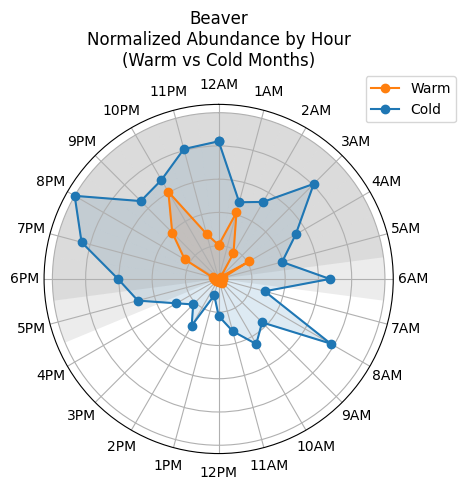

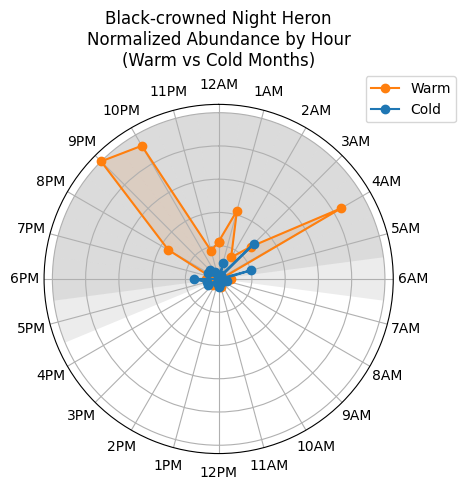

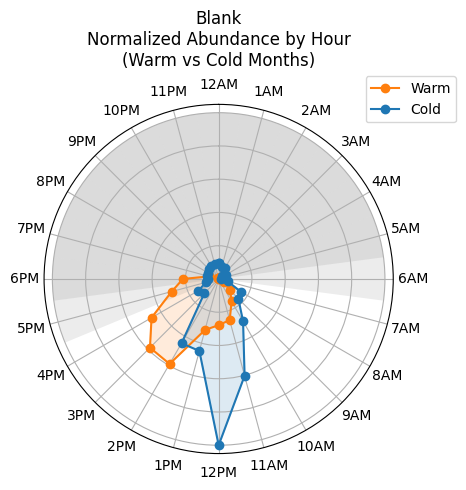

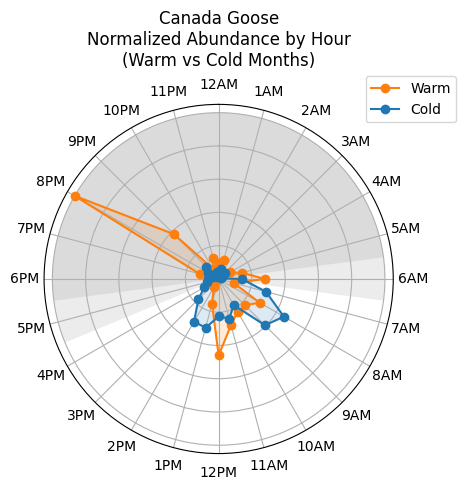

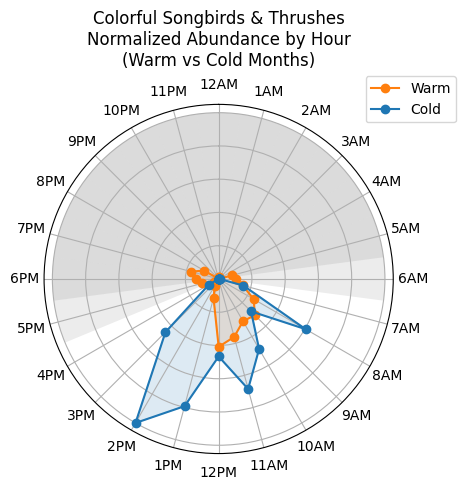

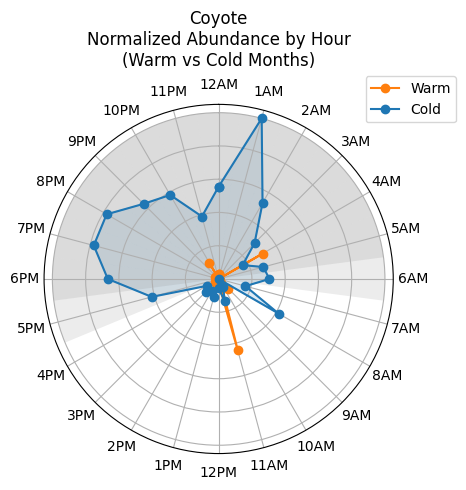

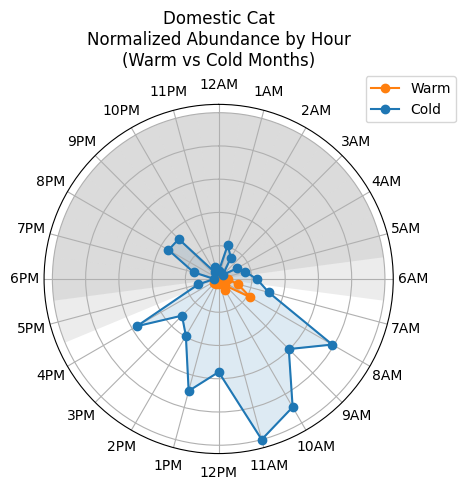

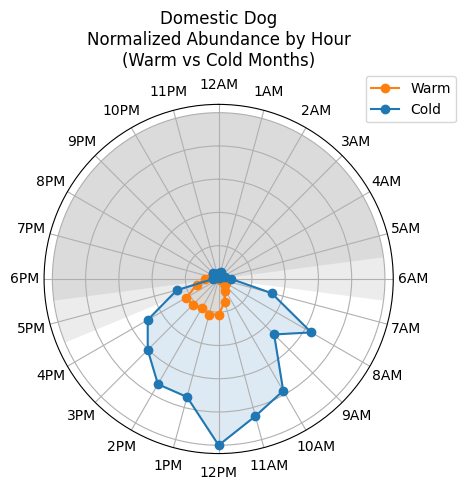

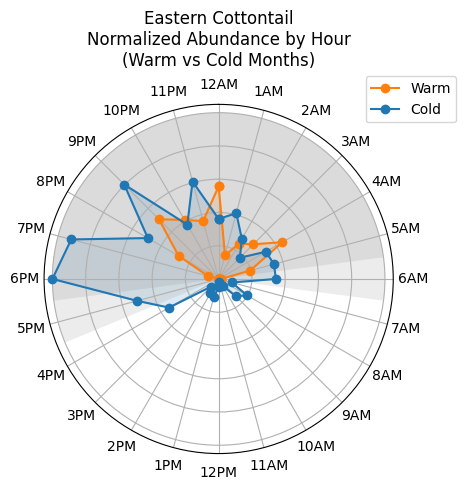

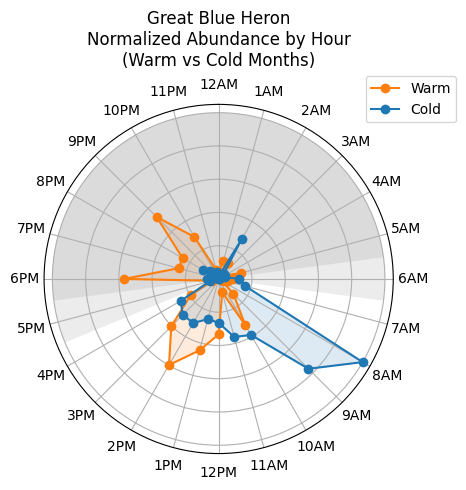

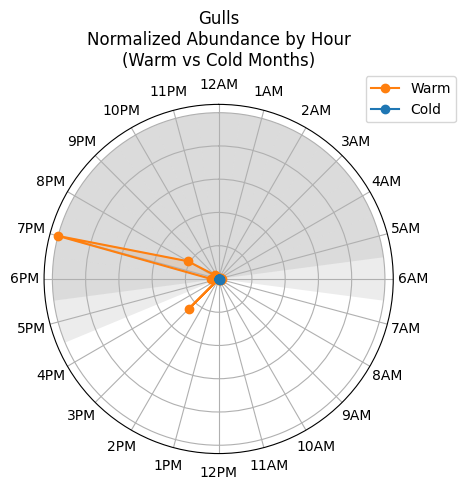

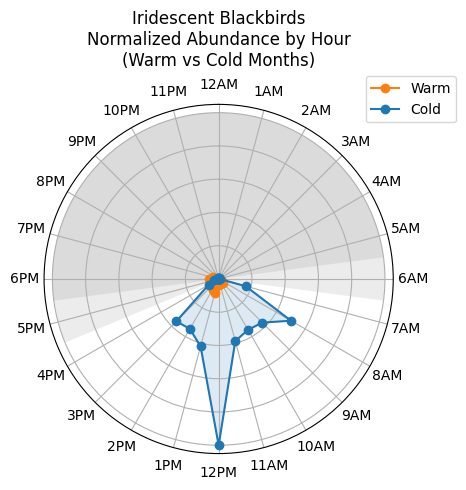

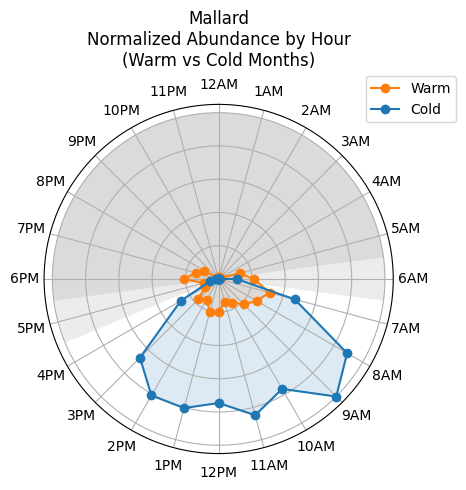

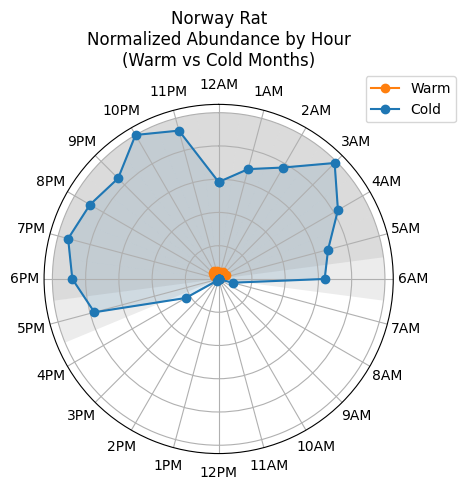

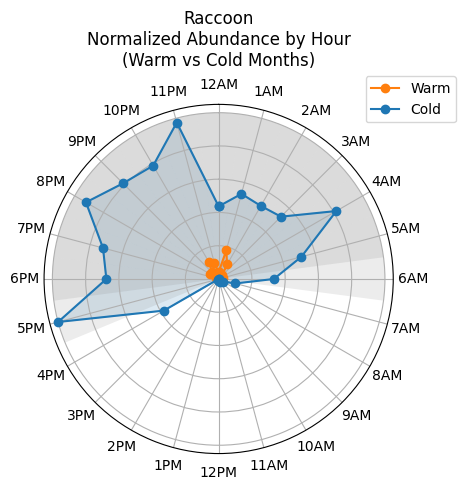

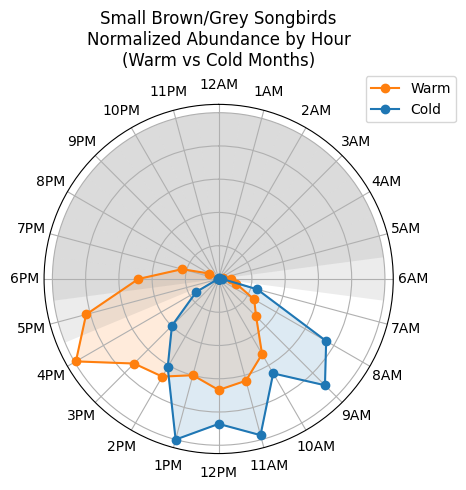

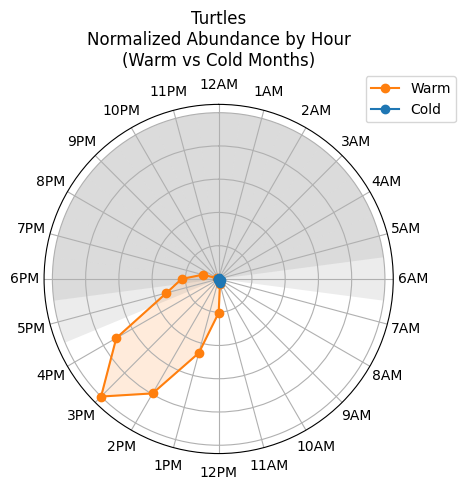

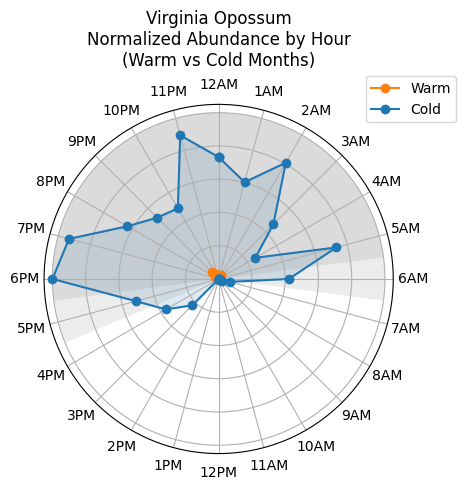

In [41]:
# Radar plots for warm vs cold months for each species
species_list = seasonal_counts['common_name'].unique()
hours = np.arange(24)
angles = np.deg2rad(hours * (360 / 24))  # map 0–23 to radians (0–2π)
hour_labels = [f"{h%12 if h%12 else 12}{'AM' if h < 12 else 'PM'}" for h in hours]

for species in species_list:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, polar=True)
    for season, color in zip(['Warm', 'Cold'], ['tab:orange', 'tab:blue']):
        data = seasonal_counts[(seasonal_counts['common_name'] == species) & (seasonal_counts['season'] == season)]
        data = data.set_index('hour').reindex(hours, fill_value=0).reset_index()
        values = data['norm_count'].values
        values = np.append(values, values[0])  # close the loop
        angles_full = np.append(angles, angles[0])
        ax.plot(angles_full, values, marker='o', color=color, label=season)
        ax.fill(angles_full, values, color=color, alpha=0.15)
    # Rotate so 12 AM is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Shade night time: from 5 PM (17) to 5 AM (5)
    night_hours = list(range(17, 24)) + list(range(0, 6))
    for h in night_hours:
        theta1 = (h / 24.0) * 360
        theta2 = ((h + 1) / 24.0) * 360
        ax.bar(
            x=np.deg2rad(np.linspace(theta1, theta2, 2)),
            height=[1, 1],
            width=np.deg2rad(theta2 - theta1),
            bottom=0,
            color='gray',
            alpha=0.15,
            edgecolor=None
        )
    ax.set_xticks(angles)
    ax.set_xticklabels(hour_labels)
    ax.set_yticklabels([])
    ax.set_title(f"{species}\nNormalized Abundance by Hour\n(Warm vs Cold Months)", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.tight_layout()
    plt.show()

### Biodiversity Score
Calculate a biodiversity score based on variety and abundance of species for a month-year combination, then plot over time.  
Use shannon index.  
https://www.statology.org/shannon-diversity-index/  
https://www.ableweb.org/biologylabs/wp-content/uploads/volumes/vol-27/22_Nolan.pdf  

Ignore "Blank" species values

C:\Users\mores\AppData\Local\Temp\ipykernel_11716\4212861477.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  biodiv_df['month_year'] = biodiv_df['timestamp'].dt.to_period('M')


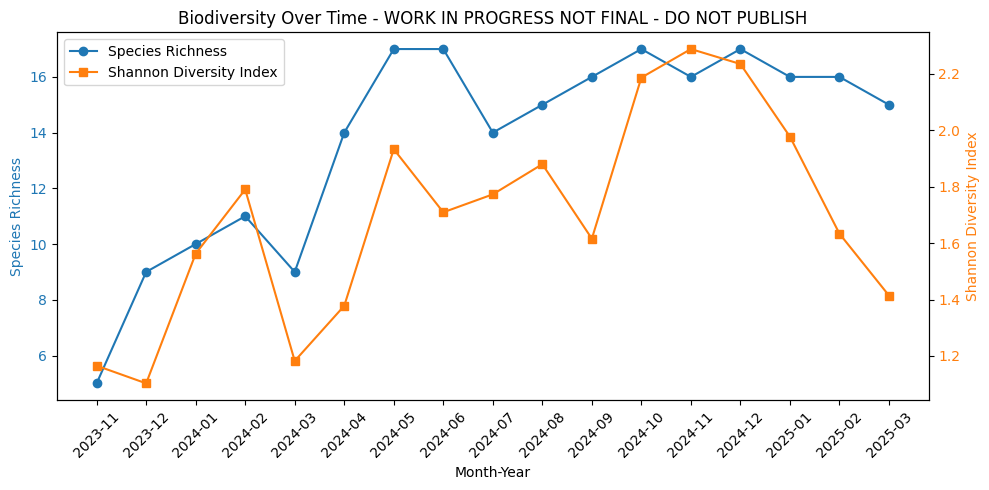

In [43]:
# Exclude "Blank" species
biodiv_df = media_preds[media_preds['common_name'] != 'Blank'].copy()

# Ensure Datetime
biodiv_df['timestamp'] = pd.to_datetime(biodiv_df['timestamp'], errors='coerce')
biodiv_df['month_year'] = biodiv_df['timestamp'].dt.to_period('M')

# Group by month-year and species
species_counts = biodiv_df.groupby(['month_year', 'common_name']).size().reset_index(name='count')

def shannon(counts):
    proportions = counts / counts.sum()
    return -np.sum(proportions * np.log(proportions + 1e-9))

# Aggregate biodiversity stats
biodiv_stats = (
    species_counts.groupby('month_year')
    .agg(
        richness=('common_name', 'nunique'),
        shannon_index=('count', shannon)
    )
    .reset_index()
)

# Filter start date
biodiv_stats = biodiv_stats[
    (biodiv_stats['month_year'] >= '2023-11') & 
    (biodiv_stats['month_year'] <= '2025-06')
    ]

# Setup plot
fig, ax1 = plt.subplots(figsize=(10, 5))

x_labels = biodiv_stats['month_year'].astype(str)
x_ticks = np.arange(len(x_labels))

# Left Y-axis: Species Richness
ax1.plot(x_ticks, biodiv_stats['richness'], marker='o', label='Species Richness', color='tab:blue')
ax1.set_ylabel('Species Richness', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('Month-Year')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels, rotation=45)

# Right Y-axis: Shannon Index
ax2 = ax1.twinx()
ax2.plot(x_ticks, biodiv_stats['shannon_index'], marker='s', label='Shannon Diversity Index', color='tab:orange')
ax2.set_ylabel('Shannon Diversity Index', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Biodiversity Over Time - WORK IN PROGRESS NOT FINAL - DO NOT PUBLISH')
plt.tight_layout()
plt.show()

Plot over time on a continuous axis
Plot by seasonality for multiple years - for a year Jan to Dec

Check number of images over years

In [37]:
biodiv_df['month_year'].value_counts().sort_index()

month_year
2011-01      36
2015-10      29
2021-01      70
2023-11       3
2024-01      44
2024-02      30
2024-03     116
2024-04    1822
2024-05    3086
2024-06    7141
2024-07     135
2024-08     236
2024-09     388
2024-10     152
2024-11    2246
2024-12    3775
2025-01    2157
2025-02    1602
2025-03     410
2029-04       1
Freq: M, Name: count, dtype: int64

#### Species Richness  
Definition: Species richness is the count of distinct species present in a defined area or time period.  
Example: If 5 unique species were detected in November 2023, then the species richness for that month is 5.

Higher richness means more types of species are present.  
It does not consider how many individuals of each species were observed — only presence.

#### Shannon Diversity Index (H')
Definition: The Shannon Index measures both richness and evenness — it accounts for the number of species and how evenly individuals are distributed across those species.  
Example: If a month has:  
- 50% Raccoons,
- 25% Deer,
- 25% Coyotes,  

then it's more diverse than a month with 90% Raccoons and 10% Deer.